# Getting the rating from the reviews

In [233]:
!pip install -q --disable-pip-version-check -r ../requirements.txt

In [271]:
# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Regular Expressions
import re

# Import unidecode (to remove accents from words)
from unidecode import unidecode

# Import wordcloud
from wordcloud import WordCloud

# Sklearn Utilities
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the information contained in a topic model
from pyLDAvis import gensim as gensimvis
import gensim

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Horizontal stack in a less memory consuming approach
from scipy.sparse import hstack

# To perform Oversampling
import nlpaug.augmenter.word as naw

# Progress bar
from tqdm import tqdm

# PyTorch Dataset
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# PyTorch Lightning NN Architecture
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer

# PyTorch Lightning Callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize

# Language Detection
from langdetect import detect

# XLNet
# from transformers import XLNetTokenizer, XLNetLMHeadModel, TextDataset, DataCollatorForLanguageModeling
# from transformers import Trainer, TrainingArguments


## GPU check

In [235]:
# Check for CUDA support
print("CUDA is available:", torch.cuda.is_available())

# Number of GPUs available
print("Number of GPUs:", torch.cuda.device_count())

# Current GPU
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())

    # GPU Name
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA is available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1650


# Preprocessing

## 1. Displaying the data

In [236]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


Obtain an example from the dataset:

In [237]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [238]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [239]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [240]:
display_ratings(reviews_df)

In [241]:
display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

## 2. Data cleaning
We will discard everything but the review *review_text* as it is the only useful for the topic modelling process

In [242]:
# Get every column and drop everything except for review_text
reviews_df = reviews_df.drop(reviews_df.columns.difference(['review_text']), axis=1)

reviews_df.head()

,review_text
0,Un hotel muy bueno. El personal fue muy amabl...
1,"Muy buen hotel al nivel de lo esperado, habita..."
2,Magnífico hotel. La verdad es que todo perfect...
3,"Hotel hermoso, buen diseño, original, limpio. ..."
4,Magnífica ubicación en pleno centro de Sevilla...


### 2.1. Removing NaN and missing values

In [243]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [244]:
has_nan_or_missing_values(reviews_df)

review_text    False
dtype: bool
Number of samples: 18172


✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [245]:
get_one_sample_with_columns(reviews_df)

[('review_text',
  'Un hotel muy bueno.  El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próxima vez en Seville por seguro. Lo recomiendo !! Y también ubicación muy cerca del centro :))))')]

Obtain more information about the dataframe:

In [246]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  18172 non-null  object
dtypes: object(1)
memory usage: 283.9+ KB


### 2.2. Text Preprocessing
We will only keep the Spanish reviews with the langdetect library. Otherwise, the TF_IDF matrix will be too sparse.

#### 2.2.1. Filter Spanish reviews

In [247]:
# Remove all non-Spanish reviews
# reviews_df = reviews_df[reviews_df['review_text'].apply(lambda x: detect(x) == 'es')]
# reviews_df.info()

In [248]:
# Reset the indeces
# reviews_df = reviews_df.reset_index(drop=True)

In [249]:
# Save the dataframe to a CSV file
# reviews_df.to_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv')

In [250]:
# Import the CSV file
reviews_df = pd.read_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

,review_text
0,Un hotel muy bueno. El personal fue muy amabl...
1,"Muy buen hotel al nivel de lo esperado, habita..."
2,Magnífico hotel. La verdad es que todo perfect...
3,"Hotel hermoso, buen diseño, original, limpio. ..."
4,Magnífica ubicación en pleno centro de Sevilla...


#### 2.2.2. Remove punctuation

In [251]:
# Remove punctuation using regular expressions
# We just keep the words and spaces
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

reviews_df.head()

,review_text
0,Un hotel muy bueno El personal fue muy amable...
1,Muy buen hotel al nivel de lo esperado habitac...
2,Magnífico hotel La verdad es que todo perfecto...
3,Hotel hermoso buen diseño original limpio Serv...
4,Magnífica ubicación en pleno centro de Sevilla...


#### 2.2.3. Transform text to lowercase

In [252]:
# Transform all words to lowercase (consistency)
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: x.lower())

reviews_df.head()

,review_text
0,un hotel muy bueno el personal fue muy amable...
1,muy buen hotel al nivel de lo esperado habitac...
2,magnífico hotel la verdad es que todo perfecto...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación en pleno centro de sevilla...


#### 2.2.3. Remove Stopwords

In [253]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [254]:
from nltk.corpus import stopwords

In [255]:
# Initialize stop words
stop_words = set(stopwords.words('spanish'))

In [256]:
# Define the text preprocessing function
def preprocess(text):
    # Remove stop words
    words = text.split()  # Split text into words
    words = [word for word in words if word not in stop_words]  # Remove stop words and stem
    return ' '.join(words)

In [257]:
reviews_df['review_text'] = reviews_df['review_text'].apply(preprocess)

reviews_df.head()

,review_text
0,hotel bueno personal amable profesional gustab...
1,buen hotel nivel esperado habitación junior su...
2,magnífico hotel verdad perfecto habitación amp...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación pleno centro sevilla recor...


## 3. Exploratory analysis
Show wordcloud to visualize possible problems in the data

In [258]:
def generate_wordcloud(df, column_name):
    # Join all reviews into a single string
    all_reviews = " ".join(df[column_name])

    # Generate the word cloud
    wordcloud = WordCloud(
        width=1600, height=800, max_font_size=200, background_color="black"
    ).generate(all_reviews)

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="black")

    # Add the title
    plt.title('Word Cloud for Reviews', fontsize=24, pad=20, color='white', fontweight='medium')

    # Display the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

    # Show the generated image
    plt.show()



c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\

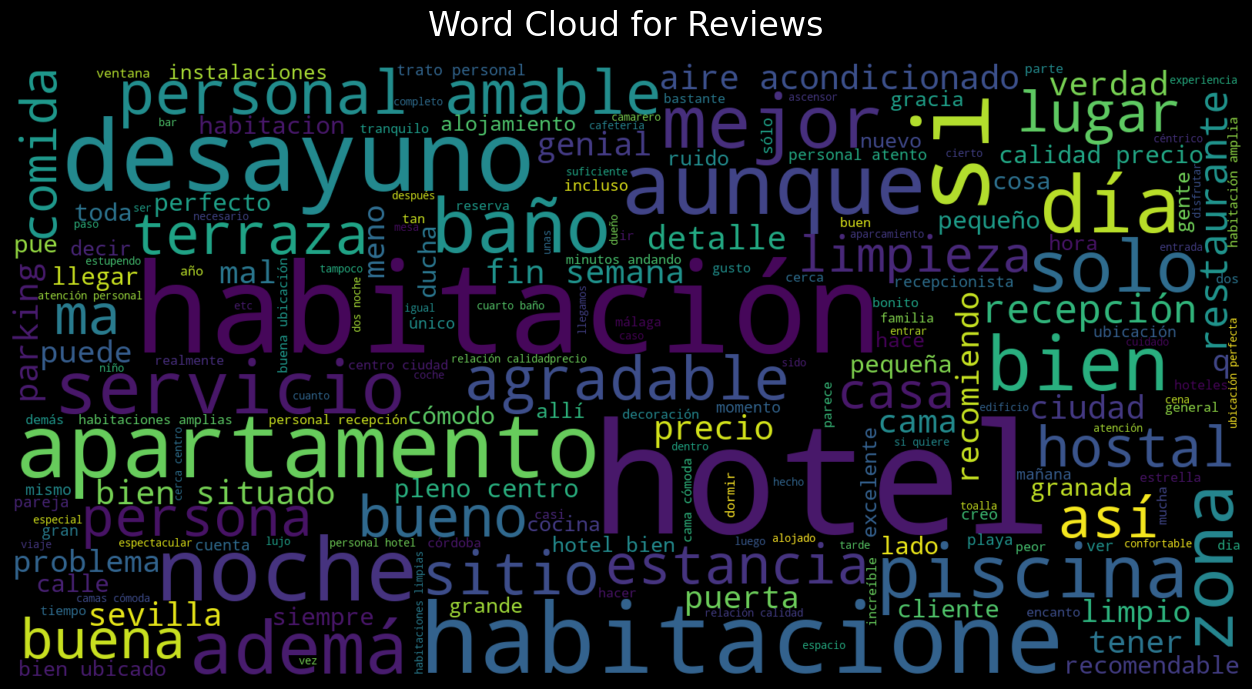

In [259]:
generate_wordcloud(reviews_df, "review_text")

### 3.1. Manual review

In [260]:
# Delete words that may be due to errors
wrong_words = ['ma']
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in wrong_words]))

## 4. LDA analysis

### 4.1. Tokenize words

In [261]:
# Donwload the resources for NLTK spanish tokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [263]:
# Tokenize the reviews if they are not already tokenized
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

### 4.2. TF-IDF Matrix - TRAIN / TEST (?)

In [264]:
# # Initialize the TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed

# # Fit and transform the tokenized text data
# tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_df['review_text'])

In [265]:
# Tokenize the reviews if they are not already tokenized
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

# Create Dictionary
id2word = corpora.Dictionary(reviews_df['review_text'])

# Create Corpus
texts = reviews_df['review_text']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


## 5. LDA Training

In [266]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

AttributeError: module 'pyLDAvis.gensim' has no attribute 'models'

### 5.1. LDA Model training

In [195]:
# # Initialize the LDA model
# lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can specify the number of topics (n_components)

# # Fit the LDA model to the TF-IDF matrix
# lda.fit(tfidf_matrix)

# # Extract the topic-word distributions
# topic_word_distributions = lda.components_

Better to use gensim library rather than scykitlearn

In [273]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.014*"hotel" + 0.014*"bien" + 0.011*"si" + 0.009*"habitación" + 0.008*"habitaciones" + 0.007*"personal" + 0.005*"zona" + 0.004*"noche" + 0.004*"puede" + 0.004*"cerca"'), (1, '0.026*"hotel" + 0.013*"habitación" + 0.008*"buena" + 0.007*"personal" + 0.007*"desayuno" + 0.007*"bien" + 0.006*"ubicación" + 0.005*"si" + 0.005*"habitaciones" + 0.005*"precio"'), (2, '0.020*"hotel" + 0.017*"habitación" + 0.010*"habitaciones" + 0.009*"bien" + 0.008*"baño" + 0.007*"buena" + 0.007*"si" + 0.007*"personal" + 0.007*"centro" + 0.006*"desayuno"'), (3, '0.014*"hotel" + 0.014*"habitación" + 0.013*"bien" + 0.007*"desayuno" + 0.006*"habitaciones" + 0.006*"centro" + 0.005*"precio" + 0.005*"si" + 0.005*"buena" + 0.005*"noche"'), (4, '0.019*"hotel" + 0.013*"personal" + 0.010*"si" + 0.007*"habitaciones" + 0.007*"centro" + 0.007*"habitación" + 0.006*"bien" + 0.006*"casa" + 0.005*"trato" + 0.005*"desayuno"'), (5, '0.007*"habitación" + 0.007*"baño" + 0.006*"hotel" + 0.006*"buena" + 0.006*"bien" + 0.005*"prec

In [197]:
# Function to display the top words for each topic
def display_topics(model, feature_names, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-num_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Display the top words for each topic
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names)

Topic 0: habitacion, bien, hotel, centro, minutos, bano, cerca, apartamento, limpio, andando
Topic 1: habitacion, hotel, si, bano, bien, mal, habitaciones, solo, noche, recepcion
Topic 2: hotel, personal, bien, buena, habitaciones, centro, desayuno, precio, cerca, amable
Topic 3: hotel, trato, personal, lugar, gracias, duda, vistas, estancia, excelente, casa
Topic 4: hotel, si, dia, lugar, casa, habitacion, reserva, piscina, solo, asi


### 5.2. Model training

In [274]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008061 -0.006698       1        1  15.491408
8      0.014849 -0.005390       2        1  13.030659
3     -0.001950 -0.011454       3        1  12.776712
0      0.002366  0.005213       4        1  11.599763
7      0.007822 -0.015950       5        1  10.510885
9     -0.001256  0.011795       6        1   9.273184
6      0.008668  0.020577       7        1   8.582510
4      0.008365  0.033228       8        1   8.581756
1      0.012623 -0.028854       9        1   5.758054
5     -0.059548 -0.002466      10        1   4.395069, topic_info=             Term          Freq         Total Category  logprob  loglift
8           hotel  13348.000000  13348.000000  Default  30.0000  30.0000
21          buena   3509.000000   3509.000000  Default  29.0000  29.0000
10       personal   5675.000000   5675.000000  Default  28.0000  28.0000
7      habitación   7808.000000   7808.000000  Default  27.0000  27.0000
101          baño   3219.000000   3219.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
5        desayuno     98.026879   4310.062698  Topic10  -5.7523  -0.6588
148     recepción     82.899761   2416.263018  Topic10  -5.9199  -0.2477
71         ciudad     79.577199   2113.336476  Topic10  -5.9608  -0.1546
20           buen     79.291603   2181.081847  Topic10  -5.9644  -0.1898
76   habitaciones     81.665641   5175.433645  Topic10  -5.9349  -1.0244

[866 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
86         1  0.166989           10
86         2  0.094551           10
86         3  0.119714           10
86         4  0.076251           10
86         5  0.064813           10
...      ...       ...          ...
118        9  0.039602         zona
118       10  0.038237         zona
17369      3  0.174615        zorro
17369      7  0.698459        zorro
17898      8  0.691880  últímamente

[2190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 4, 1, 8, 10, 7, 5, 2, 6])